<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Visualize-spatial-average-results" data-toc-modified-id="Visualize-spatial-average-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize spatial average results</a></span></li><li><span><a href="#Visualize-temporal-evolution-along-one-dimension" data-toc-modified-id="Visualize-temporal-evolution-along-one-dimension-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize temporal evolution along one dimension</a></span></li></ul></div>

# Overview
The **objective** of this notebook is to visualize the data assimilation results generated from [the DART_PFLOTRAN_Integrate notebook](./DART_PFLOTRAN_Integrate.ipynb):
1. [x] [Configuration](#parameter): define directories, file locations, and other parameters
- [x] [Visualize spatial average](#plot_spatial_average): plot the time evolution of spatial-averaged prior and posterior results
- [x] [Visualize time evolution along one axis](#plot_along_zaxis):

<a id='parameter'></a>
# Configuration

In [1]:
import os
import sys
import pickle
import f90nml
from math import floor
from datetime import datetime, timedelta
%load_ext autoreload
%autoreload 2

****************
**Define the locations of application folder, DART-PFLOTRAN interface folder, and the configuation file of interest**

In [2]:
# Main directory names
temp_app_dir = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications/template"          # The template for application folder
app_dir      = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications/1dthermal_flux_1month"          # The application folder name
dart_dir     = "/Users/jian449/Codes/DART/manhattan"
dart_pf_dir  = "/Users/jian449/Codes/DART/manhattan/models/pflotran"     # The dart pflotran utitlity folder name
# temp_app_dir = os.path.abspath("../template" )          # The template for application folder
# app_dir      = os.path.abspath("../1dthermal/")          # The application folder name
# dart_dir     = os.path.abspath("../../../../")
# dart_pf_dir  = os.path.join(dart_dir, "models/pflotran")     # The dart pflotran utitlity folder name
# Get the configuration file
config_file  = os.path.join(app_dir, "work/config.nml")

****************
**Import the visualization functions**

In [3]:
sys.path.append(dart_pf_dir)
from utils.plot_da_result import DaResults
dar = DaResults(config_file)
dar.setup(from_concatenated=True)

<a id='plot_spatial_average'></a>
# Visualize spatial average results

/usr/local/anaconda3/envs/geosci/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/usr/local/anaconda3/envs/geosci/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


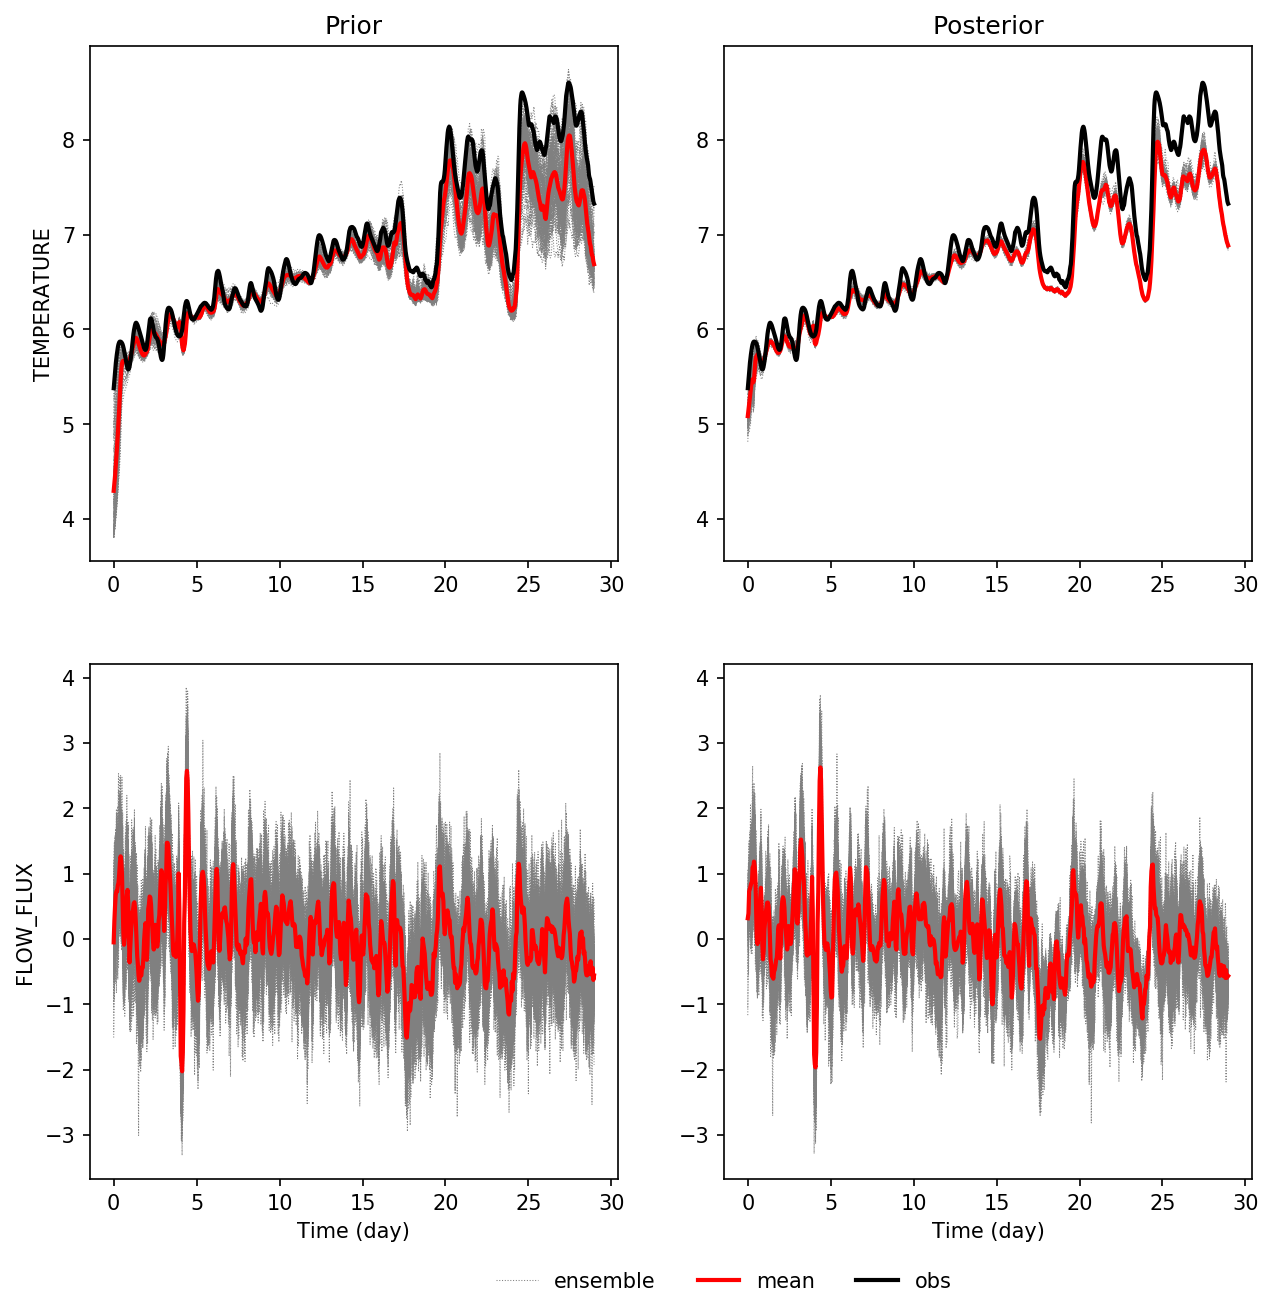

In [4]:
dar.plot_spatial_average(figsize=(10,10))

<a id='plot_along_zaxis'></a>
# Visualize temporal evolution along one dimension

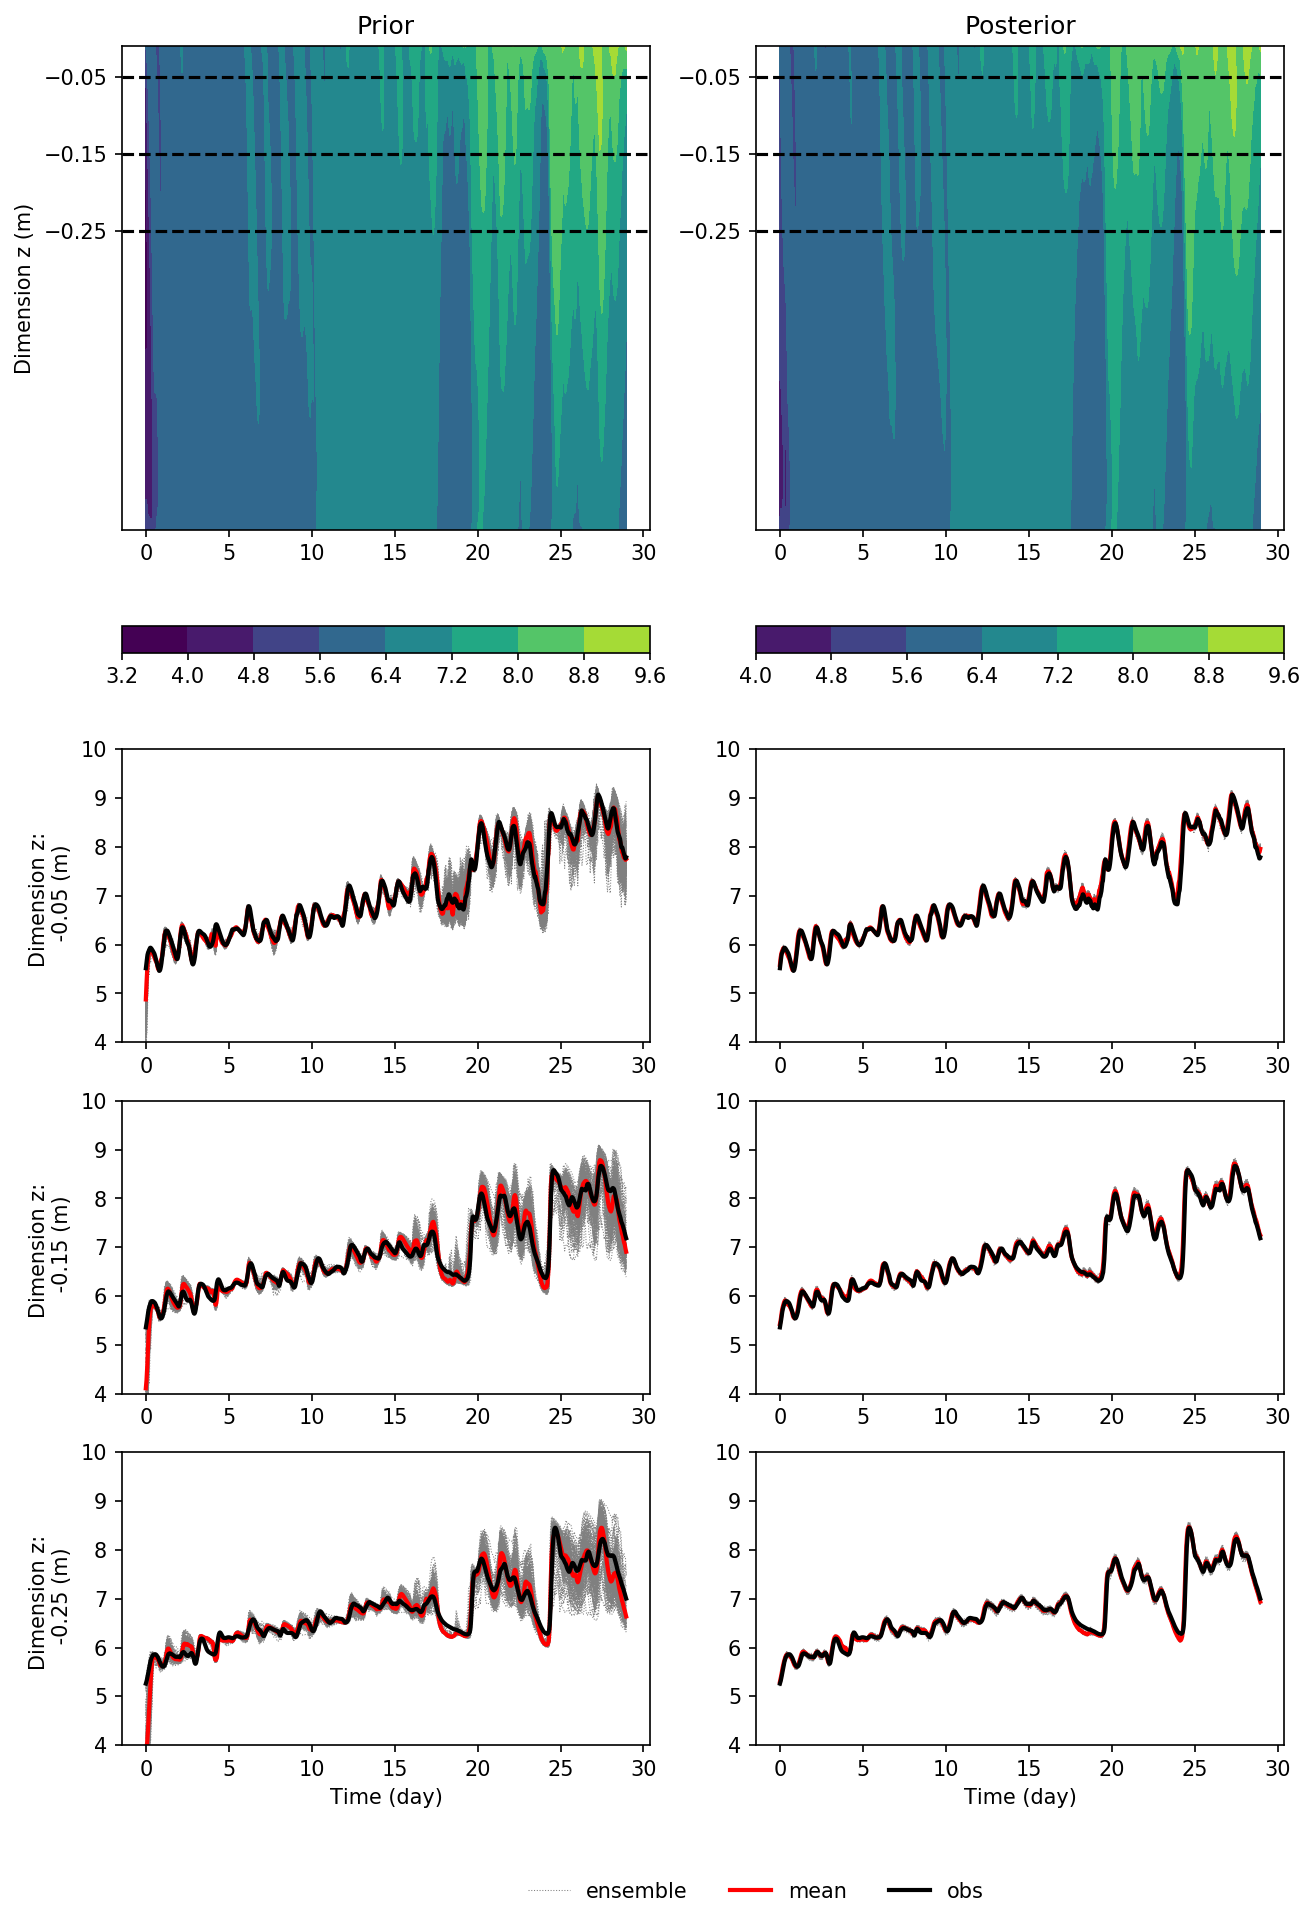

In [5]:
dar.plot_oned_obs('TEMPERATURE', figsize=(10,15), dim_str='z', vmin=4, vmax=10, ylim=[4, 10])